In [1]:
import Pkg; Pkg.activate(".")
using FRESCO
import FUSE, QED, IMAS, VacuumFields
using Plots, ProgressMeter

  Activating project at `~/.julia/dev/FRESCO/examples/VDE`


In [2]:
recycle = false
if recycle
    dd = IMAS.json2imas("./dd_iter.json")
else
    dd, ini, act = FUSE.init(:ITER, init_from=:ods);
    FUSE.ActorEquilibrium(dd, act; ip_from=:pulse_schedule);
    IMAS.imas2json(dd, "./dd_iter.json");
end;

actors: HCD
actors:  SimpleEC
actors:  SimpleIC
actors:  SimpleLH
actors:  SimpleNB
actors:  SimplePellet
actors: Current
actors:  SteadyStateCurrent
actors: CXbuild
actors: Equilibrium
actors:  TEQUILA


In [3]:
canvas0 = FRESCO.Canvas(dd, 65)
profile0 = FRESCO.PprimeFFprime(dd);

		Ψaxis			ΔΨ			Error
Iteration 1:	-88.65736178995225	91.5274839924166	0.40160496185752775
Iteration 2:	-105.0326047218839	108.34354875189013	0.3694051481190702
Iteration 3:	-109.153285567494	111.57888193485182	0.07846479398509172
Iteration 4:	-109.5529207418405	111.88351698859061	0.007322457995996628
Iteration 5:	-110.62300491455598	112.72002719685933	0.019535475010056858
Iteration 6:	-111.04154613898353	113.03145277900556	0.007566983463355268
Iteration 7:	-111.38449668419756	113.2731725014693	0.006176977125026236
Iteration 8:	-111.58111892811125	113.41417174636672	0.0035305136669273934
Iteration 9:	-111.70094018691111	113.49974436679493	0.002147697745835608
Iteration 10:	-111.77350090349003	113.55237210336375	0.001299196165359089
Iteration 11:	-111.81534944576174	113.58310352638881	0.0007488097256225715
Iteration 12:	-111.83965625866243	113.60113772699451	0.00043476701581978306
Iteration 13:	-111.85375452391796	113.61169906666714	0.00025211567572990695
Iteration 14:	-111.8618919932242

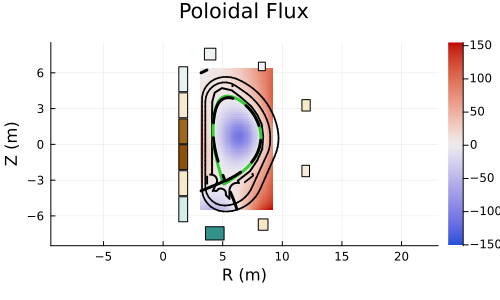

In [46]:
# Solve equilibrium with shape control to get self-consistent coil currents
canvas, profile = deepcopy(canvas0), deepcopy(profile0)
control = :shape
# Keep currents fixed in ITER OH coils (1:6), VS coils(13:14), and vacuum vessel(15:162)
fixed_coils = vcat(1:6, 13:14, 15:162) 
@time FRESCO.solve!(canvas, profile, 100, 3; control, relax=0.5, tolerance=1e-12, debug=true, initialize_current=true, fixed_coils);
plot(canvas, size=(500,300))

In [47]:
# Perturb the VS3U coil current by 1 kA (starts at 0)
canvas1, profile1 = deepcopy(canvas), deepcopy(profile)
dI_13 = 1e3
VacuumFields.set_current!(canvas1.coils[13], dI_13)
@time FRESCO.solve!(canvas1, profile1, 100, 3; relax=0.5, tolerance=1e-6, debug=true, control=:eddy, initialize_current=false, initialize_mutuals=true);

		Ψaxis			ΔΨ			Error
Iteration 1:	-111.87528013714665	113.6262598863955	4.5830467532457946e-5
Iteration 2:	-111.87100052614285	113.62232274058688	7.65068207838077e-5
Iteration 3:	-111.86967387754027	113.62155108003691	2.3717470950401615e-5
Iteration 4:	-111.86898310695503	113.62129669377832	1.2349559291523359e-5
Iteration 5:	-111.8684530132431	113.62110455997367	9.477045329415864e-6
Iteration 6:	-111.86799060457585	113.62092452022766	8.267007450111241e-6
Iteration 7:	-111.86757296393878	113.6207436045193	7.466669148349279e-6
Iteration 8:	-111.86719688718135	113.62057237722837	6.723606268899442e-6
Iteration 9:	-111.8668543124498	113.62041011587883	6.124668197291428e-6
Iteration 10:	-111.86654647300163	113.62026292866852	5.503675777084473e-6
Iteration 11:	-111.86627176378411	113.62013329560163	4.911373885803517e-6
Iteration 12:	-111.86601885155962	113.62001078382586	4.52168862891174e-6
Iteration 13:	-111.86579237835109	113.61989699552903	4.049008105464013e-6
Iteration 14:	-111.8655912391

Shift = 0.00046 m


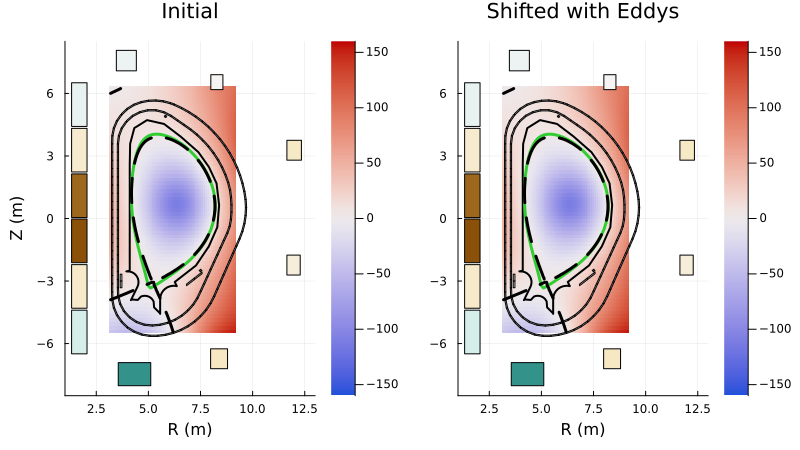

In [48]:
println("Shift = $(round(canvas1.Zaxis - canvas.Zaxis, digits=5)) m")
p1 = plot(canvas, xrange=(1,13), yrange=(-8.5,8.5), title="Initial", clims=(-160,160))
p2 = plot(canvas1, xrange=(1,13), yrange=(-8.5,8.5), title="Shifted with Eddys", clims=(-160,160), ylabel="")
plot(p1,p2, size=(800,450),left_margin=4Plots.mm)

In [49]:
# This creates a QED Build struct based on a FRESCO canvas.coils
# The voltage waveforms are set to be constant values that match V=IR
function Build(canvas)
    coils = canvas.coils
    Mcc = [VacuumFields.mutual(c1, c2) for c1 in coils, c2 in coils]
    Ic = [VacuumFields.current(c) / VacuumFields.turns(c) for c in coils] #current per turn
    Rc = [VacuumFields.resistance(c) for c in coils];
    Vc = Ic .* Rc
    V_waveforms = [QED.Waveform{Float64}(t -> Vc[k]) for k in eachindex(Vc)]
    return QED.QED_build(Ic, Vc, Rc, Mcc, V_waveforms)
end

Build (generic function with 1 method)

In [32]:
canvas_save = deepcopy(canvas);

In [50]:
Δt = 1e-3
Nt = 800
canvas = deepcopy(canvas_save)
VacuumFields.set_current!(canvas.coils[13], dI_13)
build = Build(canvas);
#canvas, profile, build = deepcopy(canvas2), deepcopy(profile2), deepcopy(build2)
#FRESCO.solve!(canvas, profile, 100, 3; relax=0.5, tolerance=1e-6, debug=true, control=:shape);

ps = Plots.Plot{Plots.GRBackend}[]
Zs = zeros(Nt+1)
Zs[1] = canvas.Zaxis
Is = zeros(length(canvas.coils), Nt*1000 + 1)
@showprogress for k in 1:Nt
    #print("$k ")
    for (k, coil) in enumerate(canvas.coils)
        VacuumFields.set_current!(coil, build.Ic[k] * VacuumFields.turns(coil))
    end
    k>1 && FRESCO.set_flux_at_coils!(canvas)
    try
        FRESCO.solve!(canvas, profile, 100, 3; relax=0.5, tolerance=1e-4, debug=false, control=:eddy, initialize_current=false, initialize_mutuals=(k==1));
    catch e
        if typeof(e) <: MethodError
            # The plasma no longer exists
            Zs[k+1:end] .= canvas.Zaxis
            Is[:, ((k-1)* 1000):end] .= Is[:, ((k-1)* 1000) - 1]
            break
        else
            rethrow(e)
        end
    end
    
    for (k, coil) in enumerate(canvas.coils)
        build.Ic[k] = VacuumFields.current(coil) / VacuumFields.turns(coil)
    end

    #R0, Z0, Ip, Vz, Ic = compute_inputs()
    #build.Vs = Voltages_from_Luke(R0, Z0, Ip, Vz, Ic)
    Zs[k+1] = canvas.Zaxis
    
    # UPDATE TO EVOLVE COUPLED SYSTEM
    Is[:, (k-1)* 1000 .+ (1:1001)] .= QED.evolve!(build, Δt, 1000)
    #@show build.Ic
    
    push!(ps, plot(canvas, xrange=(0.75,2.75), yrange=(-2,2), colorbar=false))
    #mod(k, 10) == 0 && 
    #display(plot(canvas, title = "t = $(k * Δt) s"))
end
println()


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


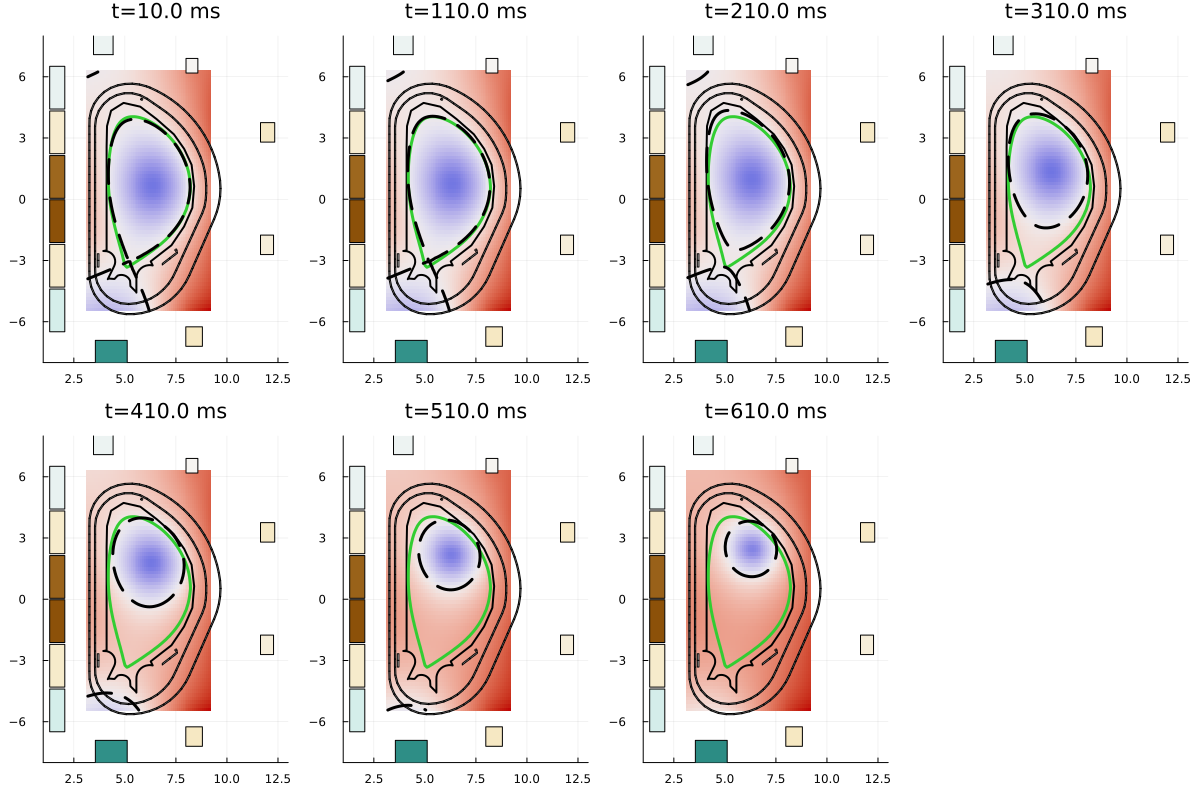

In [51]:
for (k,p) in enumerate(ps)
    plot!(p, title="t=$(round(1e3k*Δt)) ms", xlabel="", ylabel="", link=:both, xrange=(1,13),yrange=(-8,8))
end
plot(ps[vcat(10:100:end)]..., layout=(2,4), size=(1200,800))
#plot(ps[1:11]..., size=(1200,800))

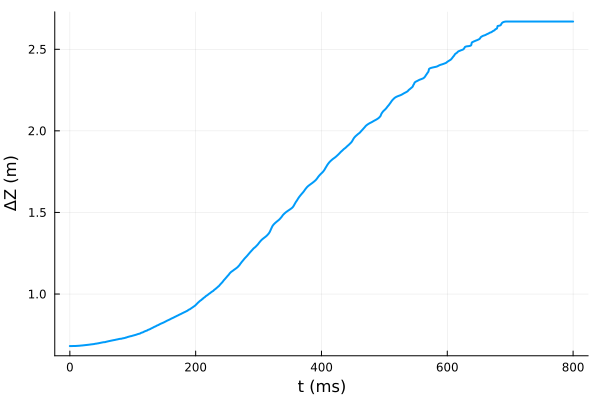

In [59]:
pz = plot(range(0.0, Nt * Δt * 1000., Nt+1), Zs, xlabel="t (ms)", ylabel="ΔZ (m)", lw=2, legend=nothing)